In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

import clip
from tqdm import tqdm

In [4]:
# ------------------
# Global Config
# ------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Hyperparameters
img_size       = 128
batch_size     = 128
epochs         = 5         
lr             = 2e-4
timesteps      = 1000
beta_start     = 1e-4
beta_end       = 0.02
clip_grad_norm = 1.0

# Create output dir for logs/checkpoints
os.makedirs('output', exist_ok=True)

Using device: cuda


## Data preprocessing

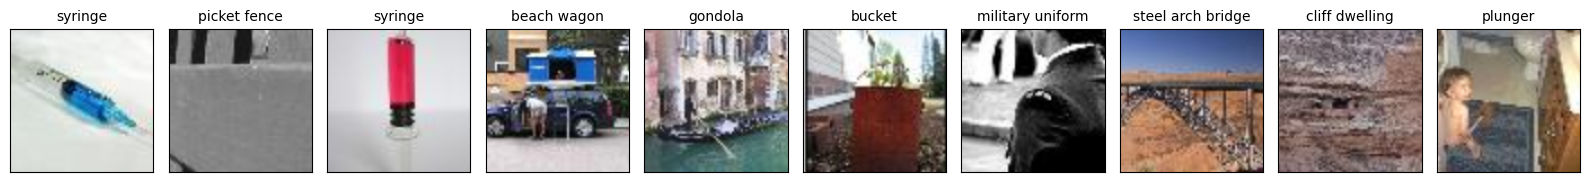

In [5]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Data paths
data_dir = "data/tiny-imagenet-200/"
words_file = "data/tiny-imagenet-200/words.txt"

# Create dataset
dataset = ImageFolder(root=f"{data_dir}/train", transform=transform)

# Create data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Read words.txt to map wnid to name
wnid_to_text = {}
with open(words_file, "r") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) == 2:
            wnid, name = parts
            wnid_to_text[wnid] = name.split(",")[0]

# Build a mapping from numerical class index to text prompt
targets_names = {}
for idx, wnid in enumerate(dataset.classes):
    if wnid in wnid_to_text:
        targets_names[int(idx)] = wnid_to_text[wnid]
    else:
        targets_names[int(idx)] = wnid  # Fallback to wnid if missing

# Save the mapping
os.makedirs('output', exist_ok=True)
json.dump(targets_names, open("output/targets_names.json", "w"), indent=4)

# Preview sample images
def preview_dataset(dataset, targets_names, num_images=10):
    fig = plt.figure(figsize=(16, 3))
    for i in range(num_images):
        k = np.random.randint(len(dataset))
        img, label = dataset[k]
        ax = fig.add_subplot(1, num_images, i+1, xticks=[], yticks=[])
        img_unnorm = img * 0.5 + 0.5  # Unnormalize
        ax.imshow(img_unnorm.permute(1, 2, 0).clamp(0, 1))
        name = targets_names[label]
        ax.set_title(name, fontsize=10)
    plt.tight_layout()
    # plt.savefig('output/sample_images.png')
    plt.show()


preview_dataset(dataset, targets_names)

In [9]:
targets_names

{0: 'goldfish',
 1: 'European fire salamander',
 2: 'bullfrog',
 3: 'tailed frog',
 4: 'American alligator',
 5: 'boa constrictor',
 6: 'trilobite',
 7: 'scorpion',
 8: 'black widow',
 9: 'tarantula',
 10: 'centipede',
 11: 'goose',
 12: 'koala',
 13: 'jellyfish',
 14: 'brain coral',
 15: 'snail',
 16: 'slug',
 17: 'sea slug',
 18: 'American lobster',
 19: 'spiny lobster',
 20: 'black stork',
 21: 'king penguin',
 22: 'albatross',
 23: 'dugong',
 24: 'Chihuahua',
 25: 'Yorkshire terrier',
 26: 'golden retriever',
 27: 'Labrador retriever',
 28: 'German shepherd',
 29: 'standard poodle',
 30: 'tabby',
 31: 'Persian cat',
 32: 'Egyptian cat',
 33: 'cougar',
 34: 'lion',
 35: 'brown bear',
 36: 'ladybug',
 37: 'fly',
 38: 'bee',
 39: 'grasshopper',
 40: 'walking stick',
 41: 'cockroach',
 42: 'mantis',
 43: 'dragonfly',
 44: 'monarch',
 45: 'sulphur butterfly',
 46: 'sea cucumber',
 47: 'guinea pig',
 48: 'hog',
 49: 'ox',
 50: 'bison',
 51: 'bighorn',
 52: 'gazelle',
 53: 'Arabian camel'

## Text Encoding

Embedding size: 512

In [6]:
class TextEncoder(nn.Module):
    """
    Wrapper around CLIP to encode text into a 512-dim vector.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.model, _ = clip.load("ViT-B/32", device=self.device)
        # Freeze CLIP
        for param in self.model.parameters():
            param.requires_grad = False
            
    def forward(self, text_list):
        # Tokenize
        tokens = clip.tokenize(text_list).to(self.device)
        with torch.no_grad():
            text_features = self.model.encode_text(tokens)
        # L2 normalize
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features  # (N, 512)

def generate_embeddings(encoder, targets_file='output/targets_names.json'):
    """
    Generate and save text embeddings for each class in your dataset.
    """
    with open(targets_file, 'r') as f:
        class_map = json.load(f)

    embeddings = {} 
    for k, name in class_map.items():
        prompt = f"a photo of a {name}"  # Example prompt
        with torch.no_grad():
            emb = encoder([prompt])  # (1, 512)
            embeddings[int(k)] = emb.squeeze(0).tolist()

    with open('output/embeddings_names.json', 'w') as f:
        json.dump(embeddings, f)


## Conditional UNet


In [7]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, cond_dim):
        super().__init__()
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.fc = nn.Linear(cond_dim, num_features*2)
        nn.init.zeros_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x, cond):
        """
        x: (B, C, H, W)
        cond: (B, cond_dim)
        """
        x_norm = self.bn(x)
        gamma_beta = self.fc(cond)
        gamma, beta = gamma_beta.chunk(2, dim=1)
        # shape => (B, C, 1, 1)
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)
        beta  = beta.unsqueeze(-1).unsqueeze(-1)
        return (1 + gamma) * x_norm + beta
    

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, dropout=0.0):
        super().__init__()
        self.conv1   = nn.Conv2d(in_channels,  out_channels, kernel_size=3, padding=1)
        self.norm1   = ConditionalBatchNorm2d(out_channels, cond_dim)
        self.conv2   = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2   = ConditionalBatchNorm2d(out_channels, cond_dim)
        self.activation = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if (in_channels != out_channels) else nn.Identity()

    def forward(self, x, cond):
        h = self.conv1(x)
        h = self.norm1(h, cond)
        h = self.activation(h)

        h = self.conv2(h)
        h = self.norm2(h, cond)
        h = self.activation(h)
        h = self.dropout(h)

        return h + self.shortcut(x)

class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)


class DownConditional(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, dropout=0.0):
        super().__init__()
        self.res = ResBlock(in_channels, out_channels, cond_dim, dropout)
        self.down = Downsample(out_channels)

    def forward(self, x, cond):
        x_res = self.res(x, cond)
        x_down = self.down(x_res)
        return x_res, x_down


class UpConditional(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, cond_dim, dropout=0.0):
        super().__init__()
        self.up  = Upsample(in_channels)
        self.res = ResBlock(in_channels + skip_channels, out_channels, cond_dim, dropout)

    def forward(self, x, skip, cond):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.res(x_cat, cond)

## Time Embedding
 
Standard sinusoidal positional embedding for the diffusion timestep.


In [8]:
class TimestepEmbedding(nn.Module):
    """
    Creates a sinusoidal positional embedding for a scalar timestep t.
    Returns a vector of dimension time_emb_dim, then projects it to final_dim.
    """
    def __init__(self, time_emb_dim=128, final_dim=512):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.fc = nn.Linear(time_emb_dim, final_dim)

    def forward(self, t):
        """
        t: (B,) or () integer time steps
        Output: (B, final_dim)
        """
        # Ensure t is float
        half_dim = self.time_emb_dim // 2
        t = t.float()
        # Expand t to shape (B, 1)
        if len(t.shape) == 0:
            t = t.unsqueeze(0)

        # Use formula from Transformer sinusoidal embeddings
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0)  # (B, half_dim)
        sin = torch.sin(emb)
        cos = torch.cos(emb)
        emb = torch.cat([sin, cos], dim=1)  # (B, time_emb_dim)

        # Project to final_dim (e.g. 512)
        emb = self.fc(emb)
        return emb

## Conditional U-Net with Time + Text Embedding
 
We combine the time embedding and the text embedding into a single `cond` vector that drives the conditional layers.



In [9]:
# Adjust decoder in ConditionalUNet

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_ch=64,
                 time_emb_dim=128, text_emb_dim=512):
        super().__init__()
        self.cond_dim = time_emb_dim + text_emb_dim
        self.time_embed = TimestepEmbedding(time_emb_dim=time_emb_dim, final_dim=time_emb_dim)

        # Encoder
        self.inc   = ResBlock(in_channels, base_ch, self.cond_dim)
        self.down1 = DownConditional(base_ch,     base_ch*2,  self.cond_dim)
        self.down2 = DownConditional(base_ch*2,   base_ch*4,  self.cond_dim)
        self.down3 = DownConditional(base_ch*4,   base_ch*8,  self.cond_dim)
        self.down4 = DownConditional(base_ch*8,   base_ch*16, self.cond_dim)
        self.down5 = DownConditional(base_ch*16,  base_ch*32, self.cond_dim)

        # Bottleneck
        self.bottleneck = ResBlock(base_ch*32, base_ch*64, self.cond_dim)

        # Decoder (remove up6)
        self.up1 = UpConditional(base_ch*64, base_ch*32, base_ch*32, self.cond_dim)
        self.up2 = UpConditional(base_ch*32, base_ch*16, base_ch*16, self.cond_dim)
        self.up3 = UpConditional(base_ch*16, base_ch*8,  base_ch*8,  self.cond_dim)
        self.up4 = UpConditional(base_ch*8,  base_ch*4,  base_ch*4,  self.cond_dim)
        self.up5 = UpConditional(base_ch*4,  base_ch*2,  base_ch*2,  self.cond_dim)

        self.outc = nn.Conv2d(base_ch*2, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t, text_emb):
        t_emb = self.time_embed(t)
        cond = torch.cat([t_emb, text_emb], dim=1)

        x1 = self.inc(x, cond)
        x2, x2_down = self.down1(x1, cond)
        x3, x3_down = self.down2(x2_down, cond)
        x4, x4_down = self.down3(x3_down, cond)
        x5, x5_down = self.down4(x4_down, cond)
        x6, x6_down = self.down5(x5_down, cond)

        bn  = self.bottleneck(x6_down, cond)

        u1 = self.up1(bn,  x6, cond)
        u2 = self.up2(u1, x5, cond)
        u3 = self.up3(u2, x4, cond)
        u4 = self.up4(u3, x3, cond)
        u5 = self.up5(u4, x2, cond)

        return self.outc(u5)


## Diffusion Class
 
 Contains forward-diffusion logic (to noise an image) and precomputes $\alpha_t$.  
 We'll add a helper to get $\sqrt{\hat{\alpha_t}}$ etc.

In [10]:
class Diffusion:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.timesteps = timesteps
        self.device    = device

        # Linear schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  

    def forward_diffusion(self, x0, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])        # (B,)
        sqrt_one_minus = torch.sqrt(1 - self.alpha_hat[t])    # (B,)

        # Reshape for broadcasting
        while len(sqrt_alpha_hat.shape) < len(x0.shape):
            sqrt_alpha_hat = sqrt_alpha_hat.unsqueeze(-1)
        while len(sqrt_one_minus.shape) < len(x0.shape):
            sqrt_one_minus = sqrt_one_minus.unsqueeze(-1)

        eps = torch.randn_like(x0)
        return sqrt_alpha_hat * x0 + sqrt_one_minus * eps, eps

    def sample_noise_process(self, x0, num_steps=8):
        """
        Return a list of images [x_0, x_t1, x_t2, ... x_tN]
        with evenly spaced timesteps for visualization.
        """
        steps = torch.linspace(0, self.timesteps - 1, num_steps).long().to(self.device)
        out = []
        current = x0.unsqueeze(0).to(self.device)
        out.append(current[0])
        for t in steps[1:]:
            noisy, _ = self.forward_diffusion(current, t.unsqueeze(0))
            out.append(noisy[0])
            current = noisy
        return out

    def q_sample(self, x0, t, noise=None):
        """
        Another convenience for the forward pass, allows specifying noise.
        """
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t]).view(-1,1,1,1)
        sqrt_one_minus = torch.sqrt(1.0 - self.alpha_hat[t]).view(-1,1,1,1)
        return sqrt_alpha_hat * x0 + sqrt_one_minus * noise

    def posterior_sample(self, model, x_t, t, text_emb):
        """
        One reverse diffusion step: predict eps, then solve for x_{t-1}.
        x_{t-1} = 1/sqrt(alpha_t) * (x_t - ((1 - alpha_t)/sqrt(1 - alpha_hat_t)) * eps_theta) + some_variance
        We'll do the simplified no-variance version here for demonstration.
        """
        betas_t    = self.betas[t].view(-1,1,1,1)
        sqrt_alpha = torch.sqrt(self.alphas[t]).view(-1,1,1,1)
        alpha_hat_t= self.alpha_hat[t].view(-1,1,1,1)

        # Predict eps via model
        eps_theta = model(x_t, t, text_emb)
        # The model is predicting the noise, so
        # x_{t-1} = 1/sqrt(alpha_t)* ( x_t - (1 - alpha_t)/ sqrt(1 - alpha_hat_t) * eps_theta )
        x_prev = (1.0 / sqrt_alpha) * (
            x_t - (betas_t / torch.sqrt(1.0 - alpha_hat_t)) * eps_theta
        )
        return x_prev

## Training Loop
 
 We'll implement:
 1. **Forward diffusion** at random timestep $ t $.  
 2. **Model** predicts the noise $\epsilon$.  
 3. **Loss** = MSE($\epsilon$, $\epsilon_\theta(x_t, t)$).  
 4. **Checkpoint** each epoch (or use a frequency).  
 


In [11]:
def train_diffusion_model(model, diffusion, train_loader, text_encoder,
                          epochs=5, lr=2e-4, timesteps=1000):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scaler    = torch.amp.GradScaler('cuda')

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch ({epoch+1}/{epochs})")
        for images, labels in pbar:
            images = images.to(device)  # (B, 3, H, W)
            # Get text embeddings
            text_prompts = []
            for lbl in labels:
                text_prompts.append(f"a photo of a {targets_names[int(lbl.item())]}")
            text_emb = text_encoder(text_prompts)  # (B, 512)

            # Sample random t in [0, timesteps-1]
            t = torch.randint(0, timesteps, (images.size(0),), device=device).long()

            # Forward diffusion to get x_t and the noise eps
            x_t, eps = diffusion.forward_diffusion(images, t)

            # Predict noise
            with torch.amp.autocast('cuda'):
                eps_pred = model(x_t, t, text_emb)
                loss = F.mse_loss(eps_pred, eps)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - loss: {avg_loss:.4f}")



        # -------------- Save checkpoint ---------------
        checkpoint_path = f"output/diffusion_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

In [10]:
# Instantiate U-Net and Diffusion
model     = ConditionalUNet(in_channels=3, out_channels=3,
                            base_ch=32, time_emb_dim=128, text_emb_dim=512).to(device)
diffusion = Diffusion(timesteps=timesteps, beta_start=beta_start, beta_end=beta_end, device=device)


encoder = TextEncoder(device)

train_diffusion_model(model, diffusion,
                      train_loader,
                      text_encoder=encoder.forward,
                      epochs=epochs,
                      lr=lr,
                      timesteps=timesteps)

Epoch (1/5):  81%|████████  | 2526/3125 [06:51<01:37,  6.14it/s, loss=0.0567]


KeyboardInterrupt: 

In [ ]:
# Instantiate U-Net and Diffusion
model     = ConditionalUNet(in_channels=3, out_channels=3,
                            base_ch=32, time_emb_dim=128, text_emb_dim=512).to(device)

model.load_state_dict(torch.load("output/diffusion_epoch_9.pth")['model_state_dict'])
model.eval()

encoder = TextEncoder(device)

diffusion = Diffusion(timesteps=timesteps, beta_start=beta_start, beta_end=beta_end, device=device)



## Visualization
 
 We'll illustrate:
 1. **(a)** Original image + progressive noise + final denoised.  
 2. **(b)** Randomly generated images (unconditional or random text).  
 3. **(c)** Text-to-image generation example.  

In [18]:
def denoise_sample(model, diffusion, x_t, t_start, text_emb):
    """
    Iteratively reverse diffuse from t_start down to t=0.
    """
    model.eval()
    with torch.no_grad():
        x_prev = x_t
        for time_step in reversed(range(0, t_start)):
            t_tensor = torch.tensor([time_step] * x_prev.size(0), device=device).long()
            x_prev   = diffusion.posterior_sample(model, x_prev, t_tensor, text_emb)
        return x_prev

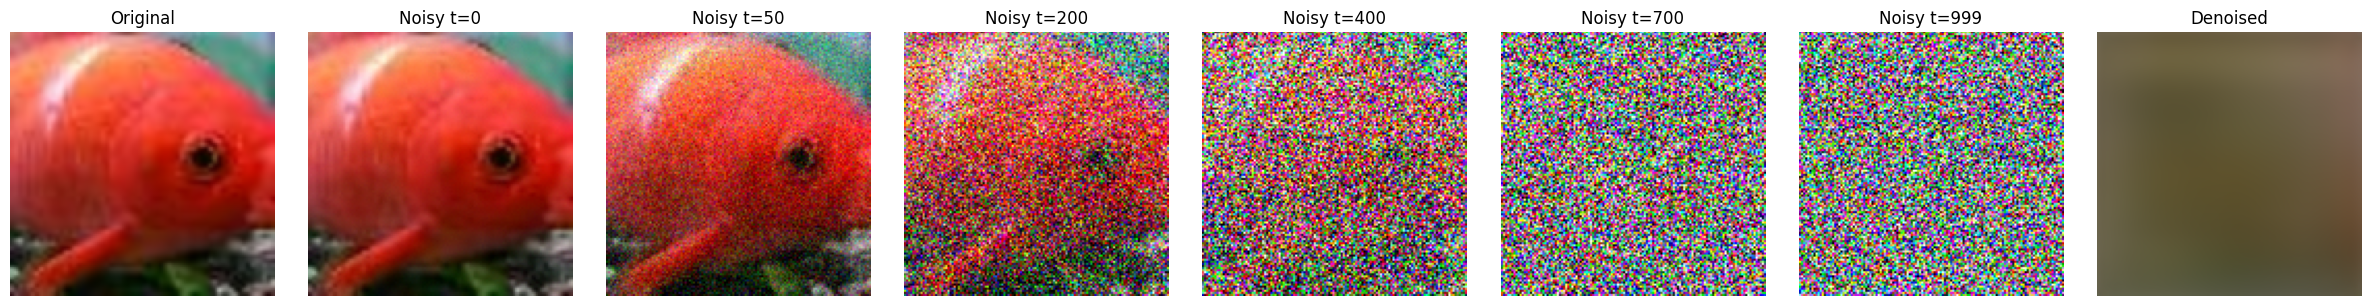

In [19]:
# (a) Original -> noise -> denoise
def visualize_diffusion_process(model, diffusion, dataset, text_encoder, idx=0):
    """
    1) Take one real image from dataset
    2) Noise it at different times
    3) Denoise from that noisy image
    4) Plot original, noisy steps, final
    """
    model.eval()
    img, label = dataset[idx]
    original   = img.unsqueeze(0).to(device)
    text_prompt = [f"a photo of a {targets_names[int(label)]}"]
    text_emb  = text_encoder(text_prompt)

    # Show original -> various timesteps noise
    steps = [0, 50, 200, 400, 700, 999]  # pick timesteps to visualize
    noisy_imgs = []
    for s in steps:
        t = torch.tensor([s], device=device).long()
        x_noisy = diffusion.q_sample(original, t)
        noisy_imgs.append(x_noisy[0].cpu())

    # Now pick the last noisy image and denoise
    last_noisy = noisy_imgs[-1].unsqueeze(0).to(device)
    denoised   = denoise_sample(model, diffusion, last_noisy, t_start=steps[-1], text_emb=text_emb)
    denoised   = denoised[0].cpu()

    # Plot
    fig, axs = plt.subplots(1, len(steps)+2, figsize=(3*(len(steps)+2), 3))
    # Original
    axs[0].imshow((original[0]*0.5+0.5).permute(1,2,0).clamp(0,1).cpu())
    axs[0].set_title("Original")
    axs[0].axis('off')

    # Noisy steps
    for i, (s, noisy_img) in enumerate(zip(steps, noisy_imgs)):
        axs[i+1].imshow((noisy_img*0.5+0.5).permute(1,2,0).clamp(0,1))
        axs[i+1].set_title(f"Noisy t={s}")
        axs[i+1].axis('off')

    # Final denoised
    axs[-1].imshow((denoised*0.5+0.5).permute(1,2,0).clamp(0,1))
    axs[-1].set_title("Denoised")
    axs[-1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_diffusion_process(model, diffusion, dataset, text_encoder=encoder.forward, idx=128)


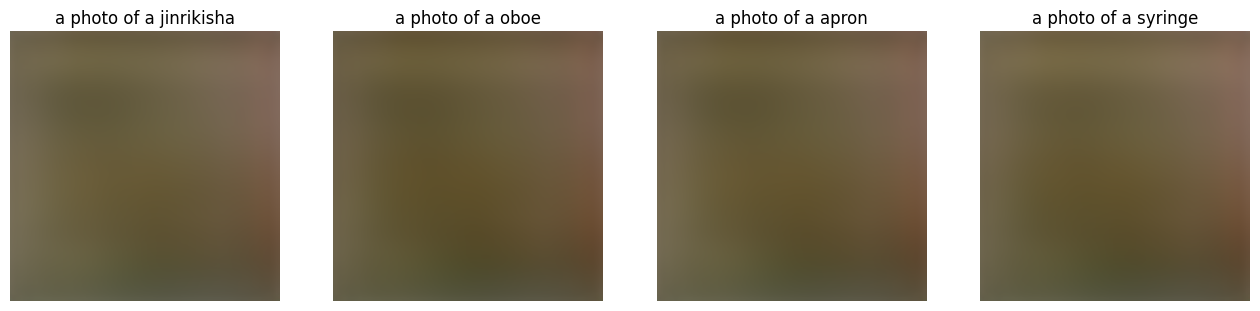

In [20]:
# (b) Random images from the model
def generate_random_images(model, diffusion, text_encoder, n=4):
    """
    For demonstration, generate n images using a random label from the dataset.
    Then run standard reverse diffusion from pure noise x_T.
    """
    model.eval()
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4))

    # random pick from dataset
    random_idx = np.random.randint(0, len(dataset), n)
    labels = [dataset[i][1] for i in random_idx]
    text_prompts = []
    for lbl in labels:
        text_prompts.append(f"a photo of a {targets_names[int(lbl)]}")
    text_emb = text_encoder(text_prompts).to(device)

    # Start from pure Gaussian noise
    x_t = torch.randn(n, 3, img_size, img_size, device=device)
    # We'll sample from t = timesteps-1 down to 0
    x_gen = denoise_sample(model, diffusion, x_t, timesteps-1, text_emb)
    
    for i in range(n):
        out_img = x_gen[i].cpu()
        axs[i].imshow((out_img*0.5+0.5).permute(1,2,0).clamp(0,1))
        axs[i].set_title(text_prompts[i])
        axs[i].axis('off')
    plt.show()

generate_random_images(model, diffusion, text_encoder=encoder.forward, n=4)


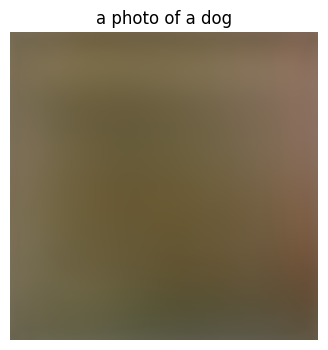

In [21]:
# (c) Custom text-to-image
def text_to_image(model, diffusion, text_prompt, text_encoder):
    """
    Start with pure noise and condition on the user-provided text_prompt
    """
    model.eval()
    text_emb = text_encoder([text_prompt]).to(device)
    x_t = torch.randn(1, 3, img_size, img_size, device=device)
    x_gen = denoise_sample(model, diffusion, x_t, timesteps-1, text_emb)
    return x_gen

prompt = "a photo of a dog"
generated = text_to_image(model, diffusion, prompt, text_encoder=encoder.forward)
plt.figure(figsize=(4,4))
plt.imshow((generated[0].cpu()*0.5+0.5).permute(1,2,0).clamp(0,1))
plt.title(prompt)
plt.axis('off')
plt.show()